Installer et importer les packages nécessaires

In [25]:
import sys
!{sys.executable} -m pip install matplotlib seaborn numpy opencv-python scikit-learn webcolors scipy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os
import glob
from collections import Counter, defaultdict
import cv2
from sklearn.cluster import KMeans
import webcolors
from scipy.spatial import distance

print("✅ Librairies chargées !")


✅ Librairies chargées !


Configuration du dataset et des styles

In [26]:
# %%
STYLES = ['boheme', 'industriel', 'minimaliste', 'moderne', 'royal', 'rustique', 'vintage']
DATASET_PATH = Path('../dataset')  # adapter selon ton projet

if not DATASET_PATH.exists():
    print("❌ Dataset non trouvé. Vérifie le chemin DATASET_PATH.")
else:
    print(f"✅ Dataset trouvé : {DATASET_PATH}")

WORKING_INFO = defaultdict(lambda: {'count':0, 'images':[]})
for style in STYLES:
    style_path = DATASET_PATH / style
    if not style_path.exists():
        continue
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        images.extend(glob.glob(str(style_path / ext)))
    WORKING_INFO[style]['count'] = len(images)
    WORKING_INFO[style]['images'] = images

print("✅ WORKING_INFO configuré pour chaque style.")


✅ Dataset trouvé : ..\dataset
✅ WORKING_INFO configuré pour chaque style.


Extraction rapide des couleurs dominantes

In [27]:
# %%
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def extract_dominant_colors_fast(image_path: str, num_colors: int = 5, resize_dim: int = 100) -> dict:
    try:
        if not os.path.exists(image_path):
            return {'success': False, 'error': f"Fichier introuvable : {image_path}"}
        image = cv2.imread(image_path)
        if image is None:
            return {'success': False, 'error': f"Impossible de charger : {image_path}"}
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (resize_dim, resize_dim), interpolation=cv2.INTER_AREA)
        pixels = image.reshape(-1, 3).astype(np.float32)
        kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=5, max_iter=200)
        kmeans.fit(pixels)
        colors_rgb = kmeans.cluster_centers_.astype(int)
        labels = kmeans.labels_
        total_pixels = len(labels)
        label_counts = Counter(labels)
        sorted_data = []
        for i in range(num_colors):
            count = label_counts[i]
            percentage = (count / total_pixels) * 100
            rgb = tuple(colors_rgb[i])
            hex_color = rgb_to_hex(rgb)
            sorted_data.append({'rgb': rgb, 'hex': hex_color, 'percentage': percentage})
        sorted_data.sort(key=lambda x: x['percentage'], reverse=True)
        return {
            'success': True,
            'colors': [item['hex'] for item in sorted_data],
            'percentages': [round(item['percentage'], 2) for item in sorted_data],
            'rgb_colors': [item['rgb'] for item in sorted_data],
            'image_path': image_path,
            'original_image': image
        }
    except Exception as e:
        return {'success': False, 'error': f"Erreur : {str(e)}"}

print("✅ Fonction extract_dominant_colors_fast prête à l'emploi.")


✅ Fonction extract_dominant_colors_fast prête à l'emploi.


Nommage des couleurs CSS3 corrigé

In [28]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


def closest_css3_color_name(rgb_tuple):
    min_dist = float('inf')
    closest_name = None

    for name in webcolors.names("css3"):
        hex_value = webcolors.name_to_hex(name, spec="css3")
        rgb = hex_to_rgb(hex_value)
        dist = distance.euclidean(rgb, rgb_tuple)

        if dist < min_dist:
            min_dist = dist
            closest_name = name

    return closest_name


def get_color_name(hex_color):
    try:
        return webcolors.hex_to_name(hex_color, spec="css3")
    except ValueError:
        return closest_css3_color_name(hex_to_rgb(hex_color))

print("✅ Nommage CSS3 prêt")


✅ Nommage CSS3 prêt


Noms décoratifs (plus humains)

In [29]:
DECOR_COLOR_MAP = {
    'beige': 'Beige',
    'linen': 'Beige clair',
    'tan': 'Beige chaud',
    'brown': 'Brun',
    'saddlebrown': 'Brun foncé',
    'peru': 'Brun clair',
    'chocolate': 'Brun chocolat',
    'maroon': 'Bordeaux',
    'rosybrown': 'Rose poudré',
    'gold': 'Or',
    'khaki': 'Kaki',
    'olive': 'Olive',
    'gray': 'Gris',
    'darkslategray': 'Gris industriel',
    'silver': 'Argent',
    'white': 'Blanc',
    'ivory': 'Blanc cassé',
    'black': 'Noir'
}


def get_pretty_color_name(hex_color):
    css = get_color_name(hex_color).lower()
    return DECOR_COLOR_MAP.get(css, css.replace('_', ' ').title())


Palette AVANCÉE avec labels

In [30]:
def draw_palette_with_labels(colors, percentages, names):
    fig, ax = plt.subplots(figsize=(8, 2))
    x_start = 0

    for color, pct, name in zip(colors, percentages, names):
        ax.barh(0, pct, left=x_start, color=color)
        ax.text(
            x_start + pct / 2,
            0,
            f"{name}\n{pct:.1f}%",
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
        x_start += pct

    ax.axis('off')
    plt.show()

print("✅ Palette avec labels prête")


✅ Palette avec labels prête


Visualisation complète image + palettes

In [31]:
def visualize_color_palette_with_names(image_path):
    result = extract_dominant_colors_fast(image_path)
    if not result['success']:
        print("❌ Erreur")
        return

    plt.figure(figsize=(4, 4))
    plt.imshow(result['original_image'])
    plt.axis('off')
    plt.title(Path(image_path).name)
    plt.show()

    names = [get_pretty_color_name(c) for c in result['colors']]
    draw_palette_with_labels(result['colors'], result['percentages'], names)


Test sur une image

📂 Style : boheme | Image : 16026.jpg


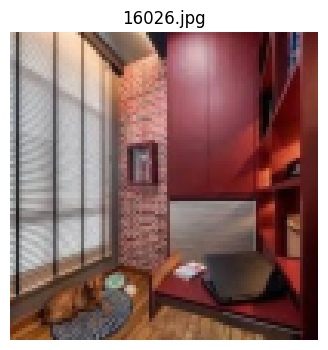

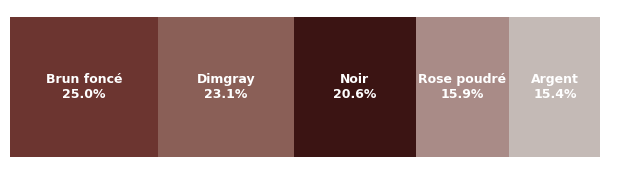

In [32]:
for style in STYLES:
    if WORKING_INFO[style]['count'] > 0:
        test_image = WORKING_INFO[style]['images'][0]
        print(f"📂 Style : {style} | Image : {Path(test_image).name}")
        visualize_color_palette_with_names(test_image)
        break

7️⃣ Galerie par style (image + palette)


In [33]:
def visualize_style_gallery_with_names(
    style_name: str,
    num_images: int = 3,
    resize_dim: int = 100
):
    if style_name not in STYLES or WORKING_INFO[style_name]['count'] == 0:
        print(f"❌ Style '{style_name}' non disponible")
        return

    images = WORKING_INFO[style_name]['images'][:num_images]

    for img_path in images:
        result = extract_dominant_colors_fast(
            img_path,
            resize_dim=resize_dim
        )

        if not result['success']:
            print(f"❌ {img_path} : {result['error']}")
            continue

        # Image originale
        plt.figure(figsize=(4, 4))
        plt.imshow(result['original_image'])
        plt.axis('off')
        plt.title(
            f"{style_name.upper()} | {Path(img_path).name}",
            fontsize=10,
            fontweight='bold'
        )
        plt.show()

        # Palette avancée avec labels
        names = [get_pretty_color_name(c) for c in result['colors']]
        draw_palette_with_labels(result['colors'], result['percentages'], names)

    print(f"✅ Galerie '{style_name}' affichée")


 Comparer tous les styles avec noms

In [34]:
def visualize_all_styles_gallery_with_names(num_images_per_style: int = 1, resize_dim: int = 100):
    for style in STYLES:
        if WORKING_INFO[style]['count'] == 0:
            continue
        print(f"🎨 Style : {style}")
        visualize_style_gallery_with_names(style, num_images=num_images_per_style, resize_dim=resize_dim)

 Test galerie multi-styles

🎨 Style : boheme


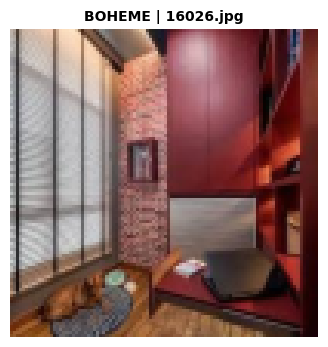

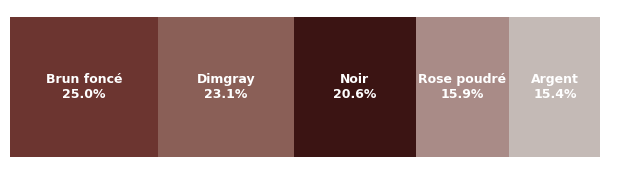

✅ Galerie 'boheme' affichée
🎨 Style : industriel


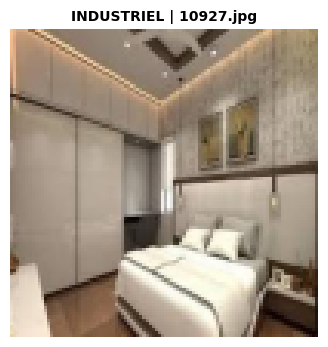

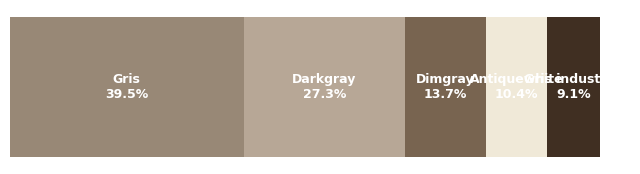

✅ Galerie 'industriel' affichée
🎨 Style : minimaliste


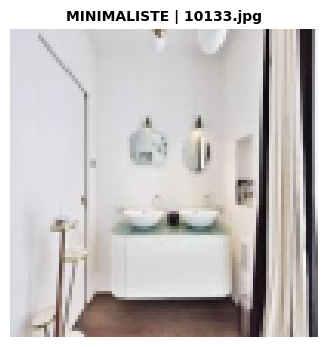

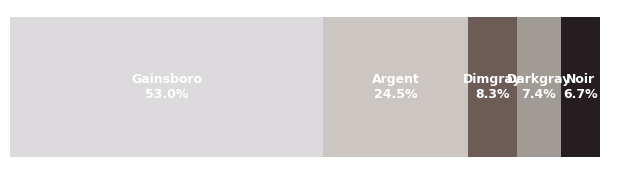

✅ Galerie 'minimaliste' affichée
🎨 Style : moderne


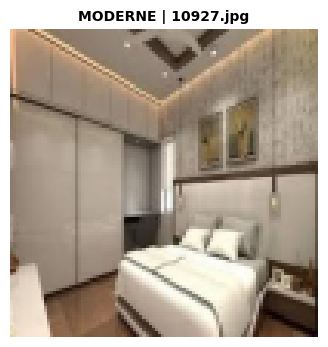

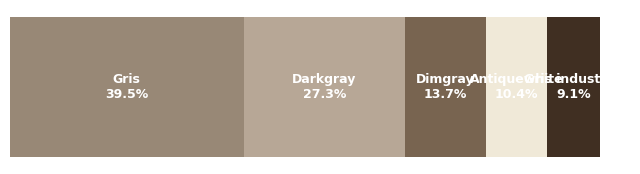

✅ Galerie 'moderne' affichée
🎨 Style : royal


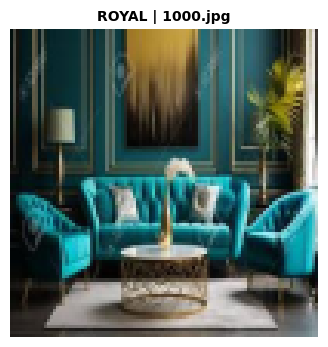

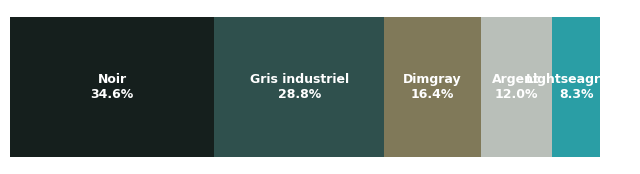

✅ Galerie 'royal' affichée
🎨 Style : rustique


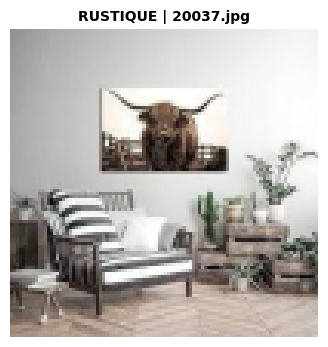

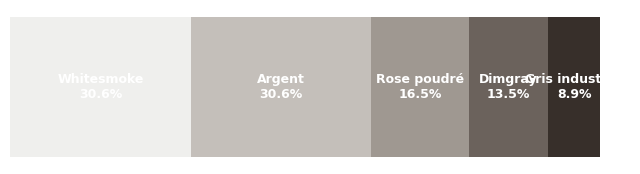

✅ Galerie 'rustique' affichée
🎨 Style : vintage


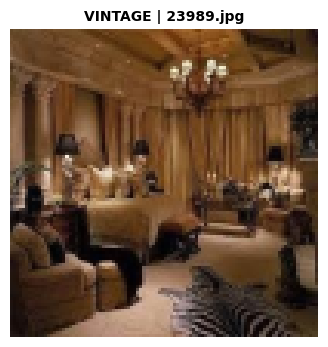

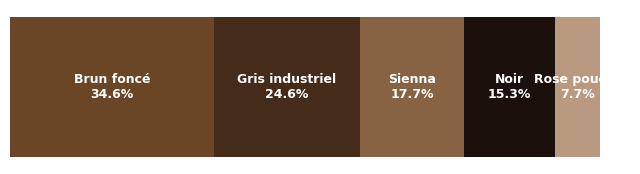

✅ Galerie 'vintage' affichée


In [35]:
visualize_all_styles_gallery_with_names(num_images_per_style=1)